In [31]:
!pip install --upgrade tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 9.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 9.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.3 MB/s eta 0:00:00a 0:00:01


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.optimizers import Adam

In [34]:
df = pd.read_csv('data/GBPUSD_open_5year.csv')
df.head()

,Unnamed: 0,Date,Open,Time
0,0,09/04/2020,1.2470,1.586390e+09
1,1,14/04/2020,1.2594,1.586822e+09
2,2,15/04/2020,1.2498,1.586909e+09
3,3,16/04/2020,1.2451,1.586995e+09
4,4,17/04/2020,1.2504,1.587082e+09


Load & split data

In [36]:
df = df.drop(columns=['Unnamed: 0', 'Time'], errors='ignore')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values('Date').set_index('Date')

print(df.head(), "\n")

              Open
Date              
2020-04-09  1.2470
2020-04-14  1.2594
2020-04-15  1.2498
2020-04-16  1.2451
2020-04-17  1.2504 



In [45]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values per column:")
print(missing)

Missing values per column:
Open    0
dtype: int64


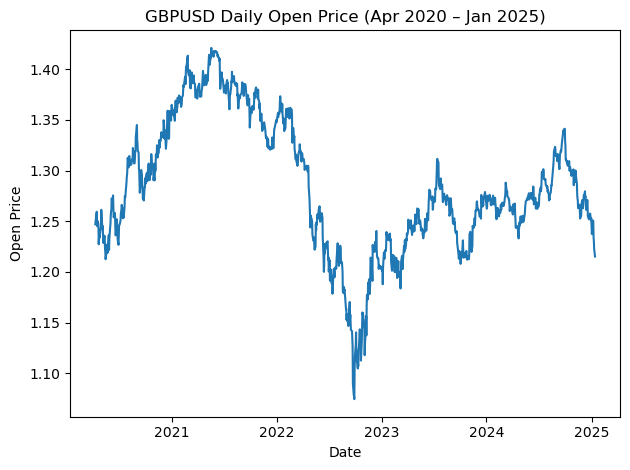

In [47]:
# Plot the time series of the Open price
plt.figure()
plt.plot(df.index, df['Open'])
plt.title('GBPUSD Daily Open Price (Apr 2020 – Jan 2025)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.tight_layout()
plt.show()

In [37]:
def split_time_series(df, train_ratio=0.7, val_ratio=0.15):
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    return df.iloc[:train_end], df.iloc[train_end:val_end], df.iloc[val_end:]

train_df, val_df, test_df = split_time_series(df)

Scale data

In [39]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['Open']])
val_scaled = scaler.transform(val_df[['Open']])
test_scaled = scaler.transform(test_df[['Open']])

In [53]:
# Create supervised sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    X, y = np.array(X), np.array(y)
    return X, y

# Prepare datasets
# Model 1: window_size = 1 (independent)
w1 = 1
X_train_1, y_train_1 = create_sequences(train_scaled, w1)
X_val_1, y_val_1 = create_sequences(val_scaled, w1)
X_test_1, y_test_1 = create_sequences(test_scaled, w1)

# Models 2-4: window_size = 10 (time series)
w2 = 10
X_train_2, y_train_2 = create_sequences(train_scaled, w2)
X_val_2, y_val_2 = create_sequences(val_scaled, w2)
X_test_2, y_test_2 = create_sequences(test_scaled, w2)
# reshape for RNNs
X_train_seq = X_train_2.reshape((X_train_2.shape[0], w2, 1))
X_val_seq   = X_val_2.reshape((X_val_2.shape[0], w2, 1))
X_test_seq  = X_test_2.reshape((X_test_2.shape[0], w2, 1))

In [61]:
# Build models
def build_dense(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(10, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

def build_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

def build_gru(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        GRU(50),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

def build_stacked_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, return_sequences=True),
        LSTM(20),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

# Example instantiation without warnings
model1 = build_dense(1)              # w1 = 1
model2 = build_lstm((10, 1))         # w2 = 10
model3 = build_gru((10, 1))
model4 = build_stacked_lstm((10, 1))

# Print summaries to verify
print(model1.summary())
print(model2.summary())
print(model3.summary())
print(model4.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,101 (62.89 KB)

 Trainable params: 16,101 (62.89 KB)

 Non-trainable params: 0 (0.00 B)

None


In [67]:
# Training
history1 = model1.fit(X_train_1, y_train_1, epochs=20, batch_size=32,
                      validation_data=(X_val_1, y_val_1), verbose=1)
history2 = model2.fit(X_train_seq, y_train_2, epochs=20, batch_size=32,
                      validation_data=(X_val_seq, y_val_2), verbose=1)
history3 = model3.fit(X_train_seq, y_train_2, epochs=20, batch_size=32,
                      validation_data=(X_val_seq, y_val_2), verbose=1)
history4 = model4.fit(X_train_seq, y_train_2, epochs=20, batch_size=32,
                      validation_data=(X_val_seq, y_val_2), verbose=1)

# Print summary of results on test set
print("Model 1 Test:", model1.evaluate(X_test_1, y_test_1, verbose=0))
print("Model 2 Test:", model2.evaluate(X_test_seq, y_test_2, verbose=0))
print("Model 3 Test:", model3.evaluate(X_test_seq, y_test_2, verbose=0))
print("Model 4 Test:", model4.evaluate(X_test_seq, y_test_2, verbose=0))

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6555 - mae: 0.7558 - val_loss: 0.3163 - val_mae: 0.5581
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5120 - mae: 0.6650 - val_loss: 0.2221 - val_mae: 0.4666
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3752 - mae: 0.5605 - val_loss: 0.1531 - val_mae: 0.3861
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2811 - mae: 0.4800 - val_loss: 0.1039 - val_mae: 0.3172
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2237 - mae: 0.4221 - val_loss: 0.0708 - val_mae: 0.2603
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1706 - mae: 0.3633 - val_loss: 0.0466 - val_mae: 0.2096
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1253 - mae: 0.3077 - val_loss: 0.0291 - val_mae: 0.1637
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0955 - mae: 0.2621 - val_loss: 0.0173 - val_mae: 0.1234
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0721 - mae: 